In [1]:
import warnings
# hide powerlaw's 'invalid value encountered in true divide' warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import powerlaw
import pylandstats as pls
import seaborn as sns
import swisslandstats as sls
from mpl_toolkits.axes_grid1 import inset_locator

from swiss_urbanization.data import settings

In [2]:
urban_class = settings.EXTRACTS_URBAN
nonurban_class = settings.EXTRACTS_NONURBAN
nodata = settings.EXTRACTS_NODATA

agglomeration_slugs = ['bern', 'lausanne', 'zurich']

In [3]:
agglomeration_dict = {}
for agglomeration_slug in agglomeration_slugs:
    ldf = sls.read_csv(
        f'../data/processed/agglomeration_extracts/{agglomeration_slug}.csv')
    landscapes = []
    dates = []
    for urban_nonurban_column in ldf.columns[ldf.columns.str.startswith('AS')]:
        landscapes.append(
            pls.Landscape(
                ldf.to_ndarray(urban_nonurban_column, nodata=nodata),
                res=ldf.res, nodata=nodata))
        # get the year of the snapshot by taking the most recurrent timestamp
        # (year) among the pixels
        dates.append(
            ldf['FJ' + urban_nonurban_column[2:4]].value_counts().index[0])
    agglomeration_dict[agglomeration_slug] = pls.SpatioTemporalAnalysis(
        landscapes, dates=dates)

In [4]:
# these will be reused throghout the plots

num_cities = len(agglomeration_slugs)
current_palette = sns.color_palette()

# get default plot dimensions to be used below
figwidth, figheight = plt.rcParams['figure.figsize']

Let us first plot the size distribution in a log-log scale

Text(0, 0.5, 'P(Area)')

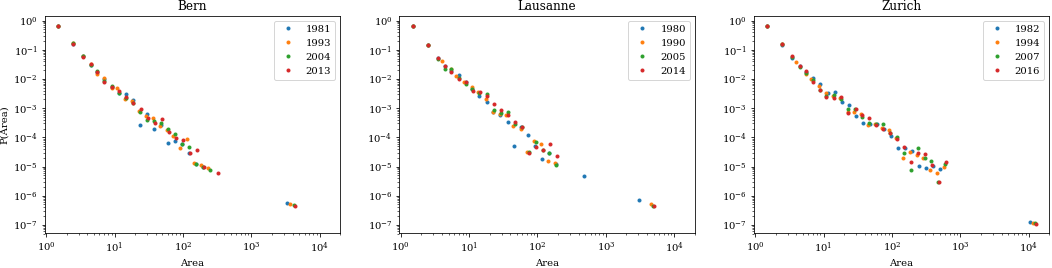

In [5]:
fig = plt.figure(figsize=(num_cities * figwidth, figheight))
ax = None  # to pass as `sharey` argument in the first iteration

for i, agglomeration_slug in enumerate(agglomeration_slugs, start=1):
    # print(agglomeration_slug.capitalize())
    sta = agglomeration_dict[agglomeration_slug]
    ax = fig.add_subplot(1, num_cities, i, sharey=ax, sharex=ax)
    ax.set_title(agglomeration_slug.capitalize())
    for k, (date, landscape) in enumerate(zip(sta.dates, sta.landscapes)):
        area_ser = landscape.area(urban_class)
        color = current_palette[k]
        powerlaw.plot_pdf(area_ser, ax=ax, color=color,
                          linestyle='None', marker='.', label=date)
        
    ax.legend()
    ax.set_xlabel('Area')

fig.axes[0].set_ylabel('P(Area)')

The scatter plot is reminiscent of a power-law (straight line), albeit some convexity might be noted. White et al. [1] also observed such convexity in Flanders, Belgium, and suggested that it is related to the high degree of urbanization of the region and the scarcity of available land. Such conditions might also apply to the context of Bern, Lausanne and Zurich.

Now let us use th Python package `powerlaw` [2] to explore to what extent the data can be approximated by a power-law distribution

In [6]:
for i, agglomeration_slug in enumerate(agglomeration_slugs, start=1):
    print(agglomeration_slug.capitalize())
    sta = agglomeration_dict[agglomeration_slug]
    for k, (date, landscape) in enumerate(zip(sta.dates, sta.landscapes)):
        area_ser = landscape.area(urban_class)
        # `xmin=1` because patches cannot have 0 area
        # `discrete=True` because patches are groups of pixels
        fit = powerlaw.Fit(
            area_ser.values, xmin=1, discrete=True, verbose=False)
        print(f'  {date}')
        R, p = fit.distribution_compare(
            'lognormal', 'power_law', nested=False, normalized_ratio=True)
        print(f'    lognormal vs power_law:            R={R:.4f}, p={p}')
        R, p = fit.distribution_compare(
            'truncated_power_law', 'power_law', nested=True, normalized_ratio=True)
        print(f'    truncated_power_law vs power_law:  R={R:.4f}, p={p}')

Bern
  1981
    lognormal vs power_law:            R=6.1478, p=7.858399875499115e-10


    truncated_power_law vs power_law:  R=6.6214, p=0.0
  1993
    lognormal vs power_law:            R=5.8208, p=5.8557635951413615e-09


    truncated_power_law vs power_law:  R=6.2261, p=0.0
  2004
    lognormal vs power_law:            R=5.8178, p=5.9619419850045626e-09


    truncated_power_law vs power_law:  R=6.2081, p=0.0
  2013
    lognormal vs power_law:            R=5.9501, p=2.6800071378369957e-09


    truncated_power_law vs power_law:  R=6.0873, p=0.0
Lausanne
  1980
    lognormal vs power_law:            R=5.7625, p=8.285580277644292e-09


    truncated_power_law vs power_law:  R=5.8414, p=0.0
  1990
    lognormal vs power_law:            R=5.7889, p=7.082821790118743e-09


    truncated_power_law vs power_law:  R=5.6793, p=0.0
  2005
    lognormal vs power_law:            R=5.8555, p=4.757088225673338e-09


    truncated_power_law vs power_law:  R=5.4947, p=0.0
  2014


    lognormal vs power_law:            R=5.8069, p=6.362962014013429e-09


    truncated_power_law vs power_law:  R=5.2667, p=0.0
Zurich
  1982


    lognormal vs power_law:            R=7.2930, p=3.030816653651468e-13


    truncated_power_law vs power_law:  R=6.4830, p=0.0
  1994


    lognormal vs power_law:            R=7.0664, p=1.590198010488531e-12


    truncated_power_law vs power_law:  R=6.2974, p=0.0
  2007


    lognormal vs power_law:            R=6.7584, p=1.3956783187760988e-11


    truncated_power_law vs power_law:  R=6.3914, p=0.0
  2016


    lognormal vs power_law:            R=7.0378, p=1.9530333978096202e-12


    truncated_power_law vs power_law:  R=5.9431, p=0.0


It seems that the best fit is a truncated power law in Bern and a lognormal distribution in Zurich and Lausanne. This suggests that the lower values of urban patch area are not so well fitted into a simple power law curve.

Let us now explore the scaling range by finding the optimal lower value of urban patch areas beyond which the scaling regime of the power law fits best by minimizng the Kolmogorov-Smirnov distance between the empirical data and the power law fit [3]:

Bern (2016):
  1981: scaling range covers 87.7542% of patches, alpha=2.0685, std err: 0.0642
  1993: scaling range covers 87.3857% of patches, alpha=1.9986, std err: 0.0601
  2004: scaling range covers 90.4827% of patches, alpha=1.9663, std err: 0.0668
  2013: scaling range covers 90.4611% of patches, alpha=1.9145, std err: 0.0630
Lausanne (2013):
  1980: scaling range covers 80.8086% of patches, alpha=2.0249, std err: 0.0529
  1990: scaling range covers 80.5744% of patches, alpha=1.9916, std err: 0.0514
  2005: scaling range covers 80.9794% of patches, alpha=1.9104, std err: 0.0474
  2014: scaling range covers 80.2398% of patches, alpha=1.8886, std err: 0.0456
Zurich (2014):
  1982: scaling range covers 85.6964% of patches, alpha=1.8288, std err: 0.0387
  1994: scaling range covers 86.9371% of patches, alpha=1.7485, std err: 0.0370
  2007: scaling range covers 86.5582% of patches, alpha=1.7156, std err: 0.0356


  2016: scaling range covers 89.1883% of patches, alpha=1.6936, std err: 0.0382


Text(0, 0.5, 'P(Area)')

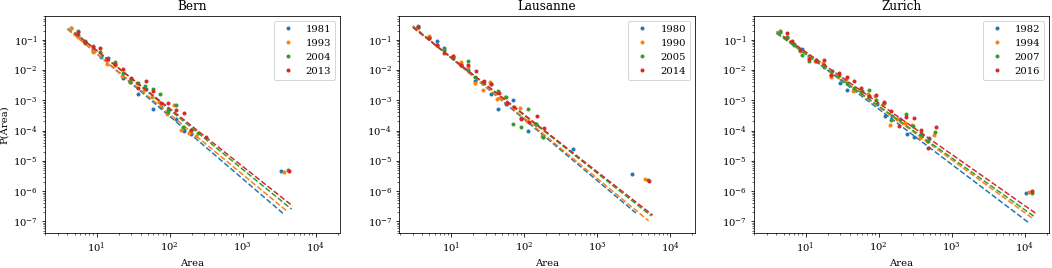

In [7]:
fig = plt.figure(figsize=(num_cities * figwidth, figheight))
ax = None  # to pass as `sharey` argument in the first iteration

for i, agglomeration_slug in enumerate(agglomeration_slugs, start=1):
    # print(agglomeration_slug.capitalize())
    sta = agglomeration_dict[agglomeration_slug]
    ax = fig.add_subplot(1, num_cities, i, sharey=ax, sharex=ax)
    print(f'{agglomeration_slug.capitalize()} ({date}):')
    for k, (date, landscape) in enumerate(zip(sta.dates, sta.landscapes)):
        area_ser = landscape.area(urban_class)
       
        ax.set_title(agglomeration_slug.capitalize())
        color = current_palette[k]

        fit = powerlaw.Fit(
            area_ser.values, discrete=True, verbose=False)
        fit.power_law.plot_pdf(ax=ax, color=color, linestyle='--')        
        print(f'  {date}: scaling range covers ' +
              f'{np.sum(area_ser < fit.xmin) * 100 / len(area_ser):.4f}% of patches' +
              f', alpha={fit.alpha:.4f}, std err: {fit.sigma:.4f}')
        powerlaw.plot_pdf(area_ser[area_ser >= fit.xmin], ax=ax, color=color,
                          linestyle='None', marker='.', label=date)        

    ax.legend()
    ax.set_xlabel('Area')

fig.axes[0].set_ylabel('P(Area)')

It seems that the power law scaling range covers most of the urban patches in all the agglomerations. In order to avoid over fitting, let us then plot a fit over the whole range of patch areas.

Bern
  1981: alpha=1.8745, std err: 0.0184
  1993: alpha=1.8623, std err: 0.0184
  2004: alpha=1.8643, std err: 0.0184
  2013: alpha=1.8623, std err: 0.0183


Lausanne


  1980: alpha=1.8617, std err: 0.0195
  1990: alpha=1.8564, std err: 0.0196
  2005: alpha=1.8490, std err: 0.0193
  2014: alpha=1.8369, std err: 0.0191
Zurich
  1982: alpha=1.8279, std err: 0.0146
  1994: alpha=1.8353, std err: 0.0149


  2007: alpha=1.8204, std err: 0.0149


  2016: alpha=1.8166, std err: 0.0148


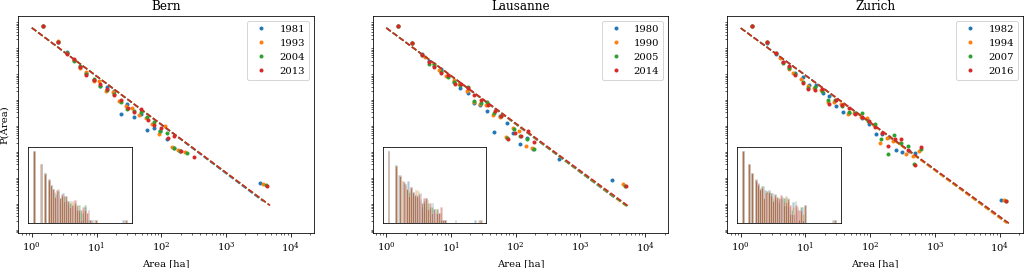

In [8]:
fig = plt.figure(figsize=(num_cities * figwidth, figheight))
ax = None  # to pass as `sharex`/`sharey` arguments in the first iteration

for i, agglomeration_slug in enumerate(agglomeration_slugs, start=1):
    # print(agglomeration_slug.capitalize())
    sta = agglomeration_dict[agglomeration_slug]
    ax = fig.add_subplot(1, num_cities, i, sharex=ax, sharey=ax)
    ax.set_title(agglomeration_slug.capitalize())
    axin = inset_locator.inset_axes(ax, width='35%', height='35%', loc=3, borderpad=1)
    print(f'{agglomeration_slug.capitalize()}')
    for k, (date, landscape) in enumerate(zip(sta.dates, sta.landscapes)):
        area_ser = landscape.area(urban_class)
        color = current_palette[k]
        powerlaw.plot_pdf(area_ser, ax=ax, color=color,
                          linestyle='None', marker='.', label=date)
        sns.distplot(
            np.log10(area_ser), kde=False, ax=axin, color=color, hist_kws={'log': True})
        # `xmin=1` because patches cannot have 0 area
        # `discrete=True` because patches are groups of pixels
        fit = powerlaw.Fit(
            area_ser.values, xmin=1, discrete=True, verbose=False)        
        fit.power_law.plot_pdf(ax=ax, color=color, linestyle='--')
        print(f'  {date}: alpha={fit.alpha:.4f}, std err: {fit.sigma:.4f}')

    ax.legend()
    ax.set_yticks([])    
    ax.set_xlabel('Area [ha]')

    if i != 1:
        ax.set_yticks([])
        axin.get_shared_x_axes().join(axin, prev_axin)
    
    axin.set_xticks([])
    axin.xaxis.label.set_visible(False)
    axin.set_yticks([])    
    prev_axin = axin

fig.axes[0].set_ylabel('P(Area)')
fig.savefig('../reports/figures/size_frequency_distribution.pdf')

## References

1. Roger White, Guy Engelen, and Inge Uljee. Modeling Cities and Regions as Complex Systems: From Theory to Planning Applications. MIT Press, 2015.
2. Jeff Alstott, Ed Bullmore, and Dietmar Plenz. powerlaw: a python package for analysis of heavy-tailed distributions. PloS one, 9(1):e85777, 2014.
3. Aaron Clauset, Cosma R. Shalizi, and Mark E. J. Newman. Power-law distributions in empirical data. arXiv preprint arXiv:0706.1062, 2007.